In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib.dates as mdates
import matplotlib as mpl

from datetime import timedelta, date, datetime
import time
import os
import pickle

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import pystarboard.data_spacescope as data_spacescope
import pystarboard.data as filecoin_data
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.date_utils as date_utils
import mechafil.data as d
import mechafil.data_spacescope as dss
import scenario_generator.utils as u
import scenario_generator.mcmc_forecast as mcmc

from cel_utils import disk_utils


In [86]:
NDEVICES = 4 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# today = date.today()
today = date(2024, 6, 1)
DATA_LAG_DAYS = 2
current_date = today - timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - date(2020, 10, 15)).days

start_date = today - timedelta(days=30)
start_day = (start_date - date(2020, 10, 15)).days

# Forecast
forecast_lenght = 365 * 3
end_day = current_day + forecast_lenght
end_date = current_date + timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)
duration = 365 # sector duration

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

auth_config=os.path.join(os.environ['HOME'], 'code', 'cel', 'auth', 'spacescope_auth.json')
assert os.path.exists(auth_config), f"Auth config not found at {auth_config}"
filecoin_data.setup_spacescope(auth_config)

2024-05-02
2024-05-30
2027-05-30


In [87]:
def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose=verbose)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose=verbose)
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats
    }
    return rb_onboard_power_pred, renewal_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, diagnostics

# def run_one_mc(i, fil_plus_rate, rb_onboard_power, renewal_rate):
#     mint_df = run_sim(fil_plus_rate, rb_onboard_power, renewal_rate)
#     mint_df['iter'] = i
#     return mint_df

# def run_sim_mc(samples_df, nj=4):
#     idxs = range(len(samples_df.index))
#     results = Parallel(n_jobs=nj)(delayed(run_one_mc)(
#         i,
#         samples_df['fil_plus_rate'].iloc[i].get(),
#         rb_onboard_power = samples_df['rb_onboard_power'].iloc[i].get(),
#         renewal_rate = samples_df['renewal_rate'].iloc[i].get()
        
#     ) for i in tqdm(idxs))
#     return results

In [88]:
offline_info_dir = 'offline'
output_dir = 'output'
os.makedirs(offline_info_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [89]:
# separate expensive preprocessing from MCMC loop
@disk_utils.cache_data(directory=offline_info_dir)
def get_offline_data():
    offline_data = data.get_simulation_data(auth_config, start_date, current_date, end_date)
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    
    return {
        'offline_data': offline_data,
        't_hist_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_hist_rr': t_hist_rr,
        'hist_rr': hist_rr,
        't_hist_fpr': t_hist_fpr,
        'hist_fpr': hist_fpr
    }

od = get_offline_data()
locals().update(od)

In [90]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 2000
num_samples_mcmc = 2000
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [91]:
# @disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    verbose=True
    rb_onboard_power_pred, renewal_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_lenght,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose)
    
    rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
    ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
    expire_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])
    
    print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
    print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
    print('Expirations Forecast RHat < 1.05: %0.02f %%' % (expire_rhat_check*100,))
    
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred':renewal_rate_pred,
        'historical_rb_date':historical_rb_date,
        'historical_rb':historical_rb,
        'historical_rr_date':historical_rr_date,
        'historical_rr':historical_rr
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

Forecasting Onboarding Power


sample: 100%|██████████| 4000/4000 [00:19<00:00, 204.07it/s, 255 steps of size 3.79e-02. acc. prob=0.90]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.00      0.02      0.00     -0.02      0.03   3159.16      1.00
       init_s[0]      0.89     18.74      0.01     -7.81      7.70    592.97      1.00
       init_s[1]     -0.10      0.23     -0.12     -0.45      0.25   4112.85      1.00
       init_s[2]      0.22      0.28      0.19     -0.24      0.62   4431.34      1.00
       init_s[3]      0.42      0.34      0.39     -0.12      0.89   2525.48      1.00
       init_s[4]      0.49      0.36      0.47     -0.11      1.03   2522.72      1.00
       init_s[5]      0.70      0.41      0.68      0.06      1.33   2312.41      1.00
       init_s[6]      0.53      0.42      0.52     -0.17      1.17   2430.10      1.00
       init_s[7]     -0.13      0.42     -0.15     -0.78      0.50   2364.39      1.00
       init_s[8]     -0.26      0.38     -0.27     -0.87      0.30   2402.30      1.00
       init_s[9]     -0.54      0.34     -

sample: 100%|██████████| 4000/4000 [01:03<00:00, 62.63it/s, 1023 steps of size 1.14e-02. acc. prob=0.79]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -2.03      4.00     -0.72     -5.31      1.04      9.07      1.19
       init_s[0]     40.01    696.87     -0.36    -96.09     94.36    122.75      1.04
       init_s[1]     10.42     26.40      7.45    -23.07     34.94    368.97      1.02
       init_s[2]     16.54     15.31     15.20    -14.05     24.33    350.56      1.02
       init_s[3]      1.77     11.59      1.29     -4.12      6.28    342.71      1.01
       init_s[4]     -4.61      3.35     -4.57     -8.95     -0.13    428.19      1.02
       init_s[5]     -0.93      2.37     -0.75     -4.51      2.78     75.47      1.03
       init_s[6]     -4.15      2.40     -4.03     -7.99     -0.46     37.56      1.05
       init_s[7]     14.44      2.76     14.67     10.20     18.74    180.96      1.03
       init_s[8]     11.85      2.55     12.04      7.91     16.03    268.73      1.03
       init_s[9]     -1.84      2.13     -

sample: 100%|██████████| 4000/4000 [00:15<00:00, 261.34it/s, 63 steps of size 4.55e-02. acc. prob=0.77] 



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.70      0.84      0.44     -0.16      1.74    545.03      1.00
       init_s[0]     -0.37     15.77     -0.02    -14.56     14.66    414.38      1.01
       init_s[1]     -0.64      1.08     -0.55     -2.45      0.99   1550.11      1.00
       init_s[2]     -0.09      1.06      0.01     -1.91      1.49    898.33      1.01
       init_s[3]      4.59      1.37      4.80      2.38      6.60    331.36      1.01
       init_s[4]     -1.28      1.05     -1.24     -3.01      0.44   2218.37      1.00
       init_s[5]     -0.79      1.07     -0.72     -2.65      0.81   2890.65      1.00
       init_s[6]      0.31      1.14      0.40     -1.54      2.05    409.61      1.00
       init_s[7]      1.97      1.20      2.14     -0.03      3.82    487.43      1.01
       init_s[8]      4.90      1.35      5.09      2.67      6.92    307.56      1.01
       init_s[9]      0.10      1.06      

In [97]:
fpr = np.ones(forecast_lenght)*0.8
lock_target = 0.8

total_samps = num_samples_mcmc * num_chains_mcmc
all_results = []
for ii in tqdm(range(total_samps)):
    rbp_i = rb_onboard_power_pred[ii]
    rr_i = renewal_rate_pred[ii]
    
    simulation_results = sim.run_sim(
        rbp_i,
        rr_i,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_lenght,
        duration,
        offline_data
    )
    all_results.append(simulation_results)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [98]:
def get_quantiles(results_vec, key, quantiles=[0.05, 0.5, 0.95]):
    # aggregate into an array
    results_aggregated = []
    for r in results_vec:
        results_aggregated.append(r[key])
    results_aggregated = np.array(results_aggregated)
    # calculate quantiles
    return np.quantile(results_aggregated, quantiles, axis=0)

def plt_x(ax, t, results, key, scale_by=1):
    cc = mpl.colormaps['Blues']
    quantiles=[0.05, 0.5, 0.95]
    cvec = np.linspace(0.2, 0.8, len(quantiles))
    qq = get_quantiles(results, key, quantiles)
    ax.plot(t, qq[1]*scale_by, color=cc(cvec[1]), label='Median')
    ax.fill_between(t, qq[0]*scale_by, qq[2]*scale_by, color=cc(cvec[0]), alpha=0.5, label='90% CI')
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

In [108]:
hist_df = filecoin_data.get_historical_network_stats(current_date-timedelta(days=365*2), current_date, current_date)

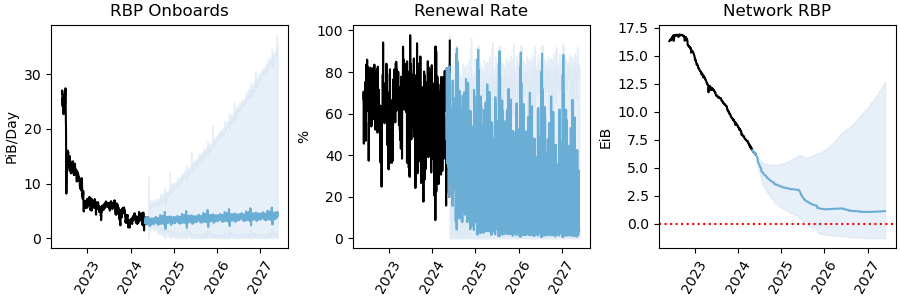

In [113]:
t = date_utils.get_t(start_date, end_date=end_date)
fig, ax = plt.subplots(1, 3, constrained_layout=True, sharex=True, figsize=(9,3))
ax[0].plot(t_hist_rbp, hist_rbp, label='Historical', color='k')
plt_x(ax[0], t, all_results, 'rb_day_onboarded_power_pib')
ax[0].set_title('RBP Onboards')
ax[0].set_ylabel('PiB/Day')
ax[1].plot(t_hist_rr, hist_rr*100, label='Historical', color='k')
plt_x(ax[1], t, all_results, 'full_renewal_rate', scale_by=100)
ax[1].set_title('Renewal Rate')
ax[1].set_ylabel('%')


ax[2].plot(hist_df['date'], hist_df['total_raw_power_eib'], label='Historical', color='k')
plt_x(ax[2], t, all_results, 'rb_total_power_eib')
ax[2].axhline(0, color='r', linestyle=':')
ax[2].set_title('Network RBP')
ax[2].set_ylabel('EiB')

plt.savefig('output/forecast_inputs.png', dpi=300)

In [100]:
def get_mint_summary(results_vec, t_vec):
    day_network_reward_results = []
    day_simple_reward_results = []
    crossing_dates_vec = []
    crossing_ix_vec = []
    for r in results_vec:
        day_network_reward = np.asarray(pd.Series(r['cum_network_reward']).diff().fillna(method='backfill'))
        day_simple_reward = np.asarray(pd.Series(r['cum_simple_reward']).diff().fillna(method='backfill'))
        day_network_reward_results.append(day_network_reward)
        day_simple_reward_results.append(day_simple_reward)

        # find date of crossing
        first_crossing = np.where((day_network_reward)*0.98 <= day_simple_reward)[0]
        if len(first_crossing) > 0:
            first_crossing = first_crossing[0]
            crossing_dates_vec.append(t_vec[first_crossing])
            crossing_ix_vec.append(first_crossing)
        
    day_network_reward_results = np.array(day_network_reward_results)
    day_simple_reward_results = np.array(day_simple_reward_results)
    crossing_ix_vec = np.array(crossing_ix_vec)

    return day_network_reward_results, day_simple_reward_results, crossing_dates_vec, crossing_ix_vec

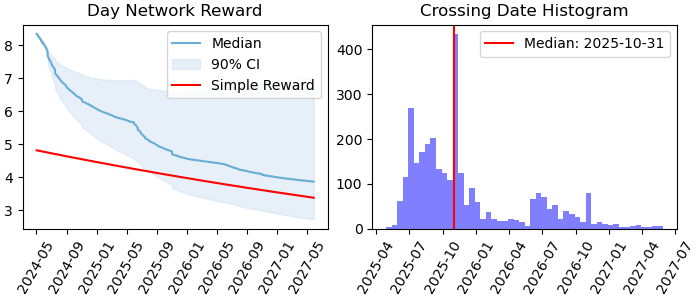

In [114]:
fig, axs = plt.subplots(1,2, constrained_layout=True, sharex=False, figsize=(7,3))

day_network_reward_results, day_simple_reward_results, crossing_dates_vec, crossing_ix_vec = get_mint_summary(all_results, t)
cc = mpl.colormaps['Blues']
quantiles=[0.05, 0.5, 0.95]
cvec = np.linspace(0.2, 0.8, len(quantiles))
qq = np.quantile(day_network_reward_results, quantiles, axis=0)
axs[0].plot(t, qq[1]/(5*2880), color=cc(cvec[1]), label='Median')
axs[0].fill_between(t, qq[0]/(5*2880), qq[2]/(5*2880), color=cc(cvec[0]), alpha=0.5, label='90% CI')
axs[0].plot(t, day_simple_reward_results[0]/(5*2880), color='red', label='Simple Reward')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(60)
axs[0].set_title('Day Network Reward')
axs[0].legend()

axs[1].hist(crossing_dates_vec, bins=50, color='blue', alpha=0.5)
mm = int(np.median(crossing_ix_vec))
closest_ix = np.argmin(np.abs(crossing_ix_vec - mm))
median_crossing = crossing_dates_vec[closest_ix]
# print(mm, crossing_ix_vec[closest_ix])
# print(crossing_dates_vec[closest_ix])

axs[1].axvline(median_crossing, color='red', label='Median: %s' % (median_crossing,))
for tick in axs[1].get_xticklabels():
    tick.set_rotation(60)
axs[1].legend()
axs[1].set_title('Crossing Date Histogram')

plt.savefig('output/minting.png', dpi=300)